## Imports 

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 

from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score 


if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()

In [15]:
os.chdir(root)
from data_treatment.box_creator import create_binary_box

df = pd.read_csv('database.csv')
df = create_binary_box(df, relative_threshold = 0.05, box_length=5).set_index("Date").dropna(axis = 0)

## Our model 

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

prescale_X = df.drop(columns="Box")
y = df[["Box"]]
#x = (prescale_X - prescale_X.mean())/prescale_X.std()

X_train, X_test, y_train, y_test = train_test_split(prescale_X, y, test_size=0.2)


from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2

selec_model = SelectKBest(k=25)
selec_model.fit(X_train, y_train)
selec_model.get_feature_names_out()

X_new = selec_model.transform(X_train)

pipe_lda = make_pipeline(SelectKBest(k=30),StandardScaler(),LinearDiscriminantAnalysis())

pipe_lda.fit(X_train,y_train)

pipe_lda.named_steps['selectkbest'].get_feature_names_out()


In [21]:
score = pipe_lda.score(X_train, y_train)
score

0.6573643410852713

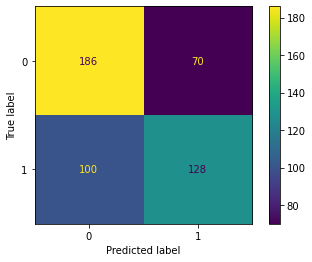

In [22]:
ConfusionMatrixDisplay.from_estimator(estimator=pipe_lda, X=X_test, y=y_test)

#### Choosing the best solver 

In [24]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['solver'] = ['svd', 'lsqr', 'eigen']
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

C:\Users\maria\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
29 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\maria\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\maria\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py", line 599, in fit
    self._solve_eigen(
  File "C:\Users\maria\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py", line 440, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "C:\Users\maria\anaconda3\

Mean Accuracy: 0.671
Config: {'solver': 'svd'}


C:\Users\maria\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
final_model = results.best_estimator_

full_pipeline= make_pipeline(StandardScaler())

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)



NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

we can see that the default SVD solver performs the best compared to the other built-in solvers

### Tuning the shrinkage hyperparameter

In [13]:
import numpy as np

model = LinearDiscriminantAnalysis(solver='lsqr')
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid

grid = dict()
grid['shrinkage'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 0.560
Config: {'shrinkage': 0.0}


C:\Users\maria\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
